In [129]:
# "Modeling of Individual HRTFs Based on Spatial Principal Component Analysis", Zhang et al. 2020
# an individual HRTF modeling method using deep neural networks based on spatial principal component analysis.
# The HRTFs are represented by a small set of spatial principal components combined with frequency and individual-dependent weights.

import numpy as np
from numpy import linalg as LA
import scipy
import scipy.io as sio
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from pylab import *
from collections import namedtuple
from os.path import dirname, join as pjoin
import sofa
import inspect

import sys
sys.path.append(r'C:\Users\root\Documents\00phd\00Code\ForSignalProcessing\spaudiopy\spaudiopy') 
# import spaudiopy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class HRTFdataclass:
    def __init__(self):
        self.fs=[]
        self.HRIR_L=[]
        self.HRIR_R=[]
        self.HRTF_L=[]
        self.HRTF_R=[]
        self.HRTFmag_L=[]
        self.HRTFmag_R=[]
        self.sid=[]
        self.ITD=[]
        self.HRTFmag_Lnew=[]
        self.HRTFmag_Rnew=[]
        self.HRTFmag_Lnewnew=[]
        self.HRTFmag_Rnewnew=[]
        self.meanHRTFmag_L=[]
        self.meanHRTFmag_R=[]
class HRTFSPCA:
    def __init__(self):
        self.nBases=[]
        self.HRTFmag_Lsynth=[]
        self.HRTFmag_Rsynth=[]
        self.MSE_L=[]
        self.MSE_R=[]
        self.L2_L=[]
        self.L2_R=[]

In [133]:
## Load HRTF data
HRTFdata=HRTFdataclass()
HRTFdata_full=[]

# Define parameters
fs = 44100
Nbases = [1,20,50,100,150,200,300,500,1000,1250]   # number of bases to be selected from 
N = 256; # FFT length

# load data
names=os.listdir('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/')
# print(names)
# column_names=['id','elevation','azimuth','hrtf']
# input=pd.DataFrame(columns=column_names)
# input.id=names[1:]
# print(input)

for i in range(1, len(names)):  
    data_dir = pjoin('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/', names[i])
    mat_fname = pjoin(data_dir, 'hrir_final.mat')
    data=sio.loadmat(mat_fname)

    HRTFdata=HRTFdataclass()
    HRTFdata.fs=fs
    HRTFdata.sid=names[i] 
    HRTFdata.HRIR_L=data.get('hrir_l')
    HRTFdata.HRIR_R=data.get('hrir_r')
    HRTFdata.HRTF_L=scipy.fft.rfft(HRTFdata.HRIR_L,N,axis=-1)
    HRTFdata.HRTF_R=scipy.fft.rfft(HRTFdata.HRIR_R,N,axis=-1)
    HRTFdata.HRTFmag_L=20*np.log10(np.abs(HRTFdata.HRTF_L))
    HRTFdata.HRTFmag_R=20*np.log10(np.abs(HRTFdata.HRTF_R))
    HRTFdata.ITD=data.get('ITD')
    HRTFdata.HRTFmag_Lnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.HRTFmag_Rnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.HRTFmag_Lnewnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.HRTFmag_Rnewnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.meanHRTFmag_L=np.zeros(HRTFdata.HRTF_L.shape[2])
    HRTFdata.meanHRTFmag_R=np.zeros(HRTFdata.HRTF_L.shape[2])
    HRTFdata.HRTFmag_Lsynth=np.zeros(np.append(HRTFdata.HRTF_L.shape,len(Nbases)))
    HRTFdata.HRTFmag_Rsynth=np.zeros(np.append(HRTFdata.HRTF_L.shape,len(Nbases)))
    
    HRTFdata_full.append(HRTFdata) 

In [150]:
# compute mean HRTF magnitude over all subjects and directions 
# (it includes the direction and subject independent spectral features shared by all HRTFs)
meanHRTFmag=np.zeros(HRTFdata_full[0].HRTF_L.shape[2])
sum_L=np.zeros(HRTFdata_full[0].HRTF_L.shape[2])   
sum_R=np.zeros(HRTFdata_full[0].HRTF_L.shape[2])
for i in range(0, len(HRTFdata_full)): # for each subject
    meanHRTFmag= meanHRTFmag+np.sum(HRTFdata_full[i].HRTFmag_L,axis=(0,1))+HRTFdata_full[i].meanHRTFmag_R # sum over all subjects

meanHRTFmag=meanHRTFmag/(len(HRTFdata_full)*2*HRTFdata_full[0].HRTF_L[:,:,0].size) #mean over all subjects and all directions

# remove the mean HRTF magnitude from all HRTFs
for i in range(0, len(HRTFdata_full)): # for each subject
    HRTFdata_full[i].HRTFmag_Lnew=HRTFdata_full[i].HRTFmag_L-meanHRTFmag
    HRTFdata_full[i].HRTFmag_Rnew=HRTFdata_full[i].HRTFmag_R-meanHRTFmag

In [148]:
print(meanHRTFmag)

[-1.38821530e-02 -6.24989328e-03 -1.37354248e-03 -1.03675932e-04
  7.04797895e-04  2.27776468e-04  1.86331435e-05  1.14879675e-03
  1.72537227e-03  2.58553674e-03  2.83319549e-03  3.19355445e-03
  3.50567277e-03  4.07347486e-03  4.73538262e-03  5.46998987e-03
  6.52894755e-03  7.71778343e-03  8.76724489e-03  9.47829193e-03
  1.05145326e-02  1.12761057e-02  1.19093494e-02  1.24570837e-02
  1.26764235e-02  1.26454564e-02  1.23892664e-02  1.21816913e-02
  1.18069422e-02  1.15473947e-02  1.12028540e-02  1.08975571e-02
  1.06444536e-02  1.03173053e-02  1.00336327e-02  9.73512396e-03
  9.31774162e-03  8.91718223e-03  8.48994715e-03  8.05235419e-03
  7.56770931e-03  7.04632960e-03  6.50711467e-03  6.03054587e-03
  5.52466534e-03  4.98255706e-03  4.43886464e-03  3.92082168e-03
  3.60417337e-03  3.44558331e-03  3.28182225e-03  3.08661619e-03
  2.71999242e-03  2.34335825e-03  1.98923588e-03  1.62355048e-03
  1.26263807e-03  8.34341769e-04  4.79088667e-04  2.04909961e-04
  2.32384136e-05 -3.32942

(129,)


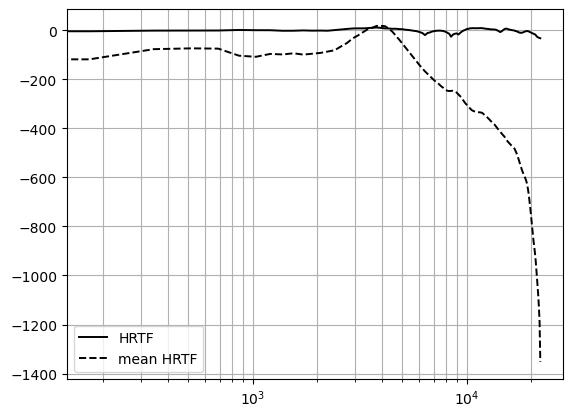

In [151]:
print(meanHRTFmag.shape)

freq=np.linspace(0, math.ceil(N/2), math.ceil(N/2)+1)*fs/N
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_L[11,4,:],'k',linewidth=1.4, label='HRTF')
plt.semilogx(freq,meanHRTFmag,'--k',linewidth=1.4, label='mean HRTF')
plt.grid(True, which="both", ls="-")
plt.legend()

In [4]:
# Compute mean spatial function over all frequencies and subjects 
meanHRTFmagnew_L=np.zeros(HRTFdata_full[0].HRTF_L.shape[0:2])
meanHRTFmagnew_R=np.zeros(HRTFdata_full[0].HRTF_L.shape[0:2])
for i in range(0, len(HRTFdata_full)): # for each subject
    meanHRTFmagnew_L = meanHRTFmagnew_L+np.squeeze(np.sum(HRTFdata_full[i].HRTFmag_Lnew,axis=2)) 
    meanHRTFmagnew_R = meanHRTFmagnew_R+np.squeeze(np.sum(HRTFdata_full[i].HRTFmag_Rnew,axis=2)) 
meanHRTFmagnew_L = meanHRTFmagnew_L/(len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_Lnew.shape[2]) 
meanHRTFmagnew_R = meanHRTFmagnew_L/(len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_Lnew.shape[2])
# remove mean spatial function
for i in range(0, len(HRTFdata_full)): # for each subject
    for j in range(0, HRTFdata_full[0].HRTFmag_Lnew.shape[2]):  # for each frequency
        HRTFdata_full[i].HRTFmag_Lnewnew[:,:,j] = np.squeeze(HRTFdata_full[i].HRTFmag_Lnew[:,:,j])-meanHRTFmagnew_L
        HRTFdata_full[i].HRTFmag_Rnewnew[:,:,j] = np.squeeze(HRTFdata_full[i].HRTFmag_Rnew[:,:,j])-meanHRTFmagnew_R

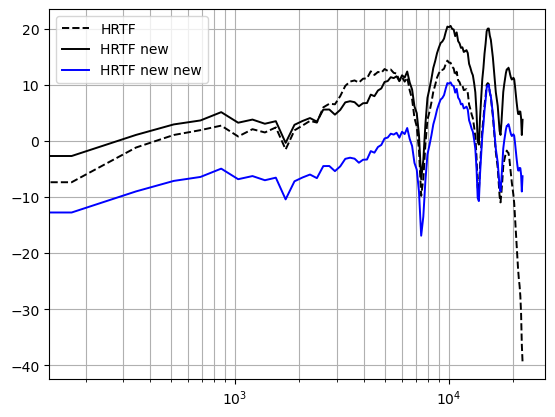

In [44]:
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_L[0,0,:],'--k',linewidth=1.4, label='HRTF')
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Lnew[0,0,:],'k',linewidth=1.4, label='HRTF new')
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Lnewnew[0,0,:],'b',linewidth=1.4, label='HRTF new new')
plt.grid(True, which="both", ls="-")
plt.legend()

In [60]:
## Estimate spatial principal components
# 2NS x D matrix of HRTFmag_newnew 
H_L=np.zeros((len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_Lnewnew.shape[2],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0]*HRTFdata_full[0].HRTFmag_Lnewnew.shape[1]))
H_R=np.zeros((len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_Lnewnew.shape[2],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0]*HRTFdata_full[0].HRTFmag_Lnewnew.shape[1]))
for i in range(0, len(HRTFdata_full)): 
    for j in range(0, HRTFdata_full[0].HRTF_L.shape[2]):  # each frequency
        for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]):
            for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
                H_L[len(HRTFdata_full)*i+j,HRTFdata_full[0].HRTF_L.shape[0]*l+k]=HRTFdata_full[i].HRTFmag_Lnewnew[k,l,j]   # Each column of H corresponds to a spatial direction, and each row of H represents the HRTF of an individual at a discrete frequency.
                H_R[len(HRTFdata_full)*i+j,HRTFdata_full[0].HRTF_L.shape[0]*l+k]=HRTFdata_full[i].HRTFmag_Rnewnew[k,l,j]   # right ear
COV_L=np.cov(H_L.transpose()) # covariance matrix
COV_R=np.cov(H_R.transpose())
pass
eigen_valL, eigen_vecL = LA.eig(COV_L)
eigen_valR, eigen_vecR = LA.eig(COV_R)
var_L=np.zeros(eigen_vecL.shape[1])
var_R=np.zeros(eigen_vecL.shape[1])

In [82]:
SPC_L=np.zeros(np.append(eigen_vecL.shape[0],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0:2]))
SPC_R=np.zeros(np.append(eigen_vecL.shape[0],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0:2]))
for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]):
    for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
        SPC_L[:,k,l]=eigen_vecL[:,k+l*HRTFdata_full[0].HRTF_L.shape[0]]
        SPC_R[:,k,l]=eigen_vecR[:,k+l*HRTFdata_full[0].HRTF_L.shape[0]]

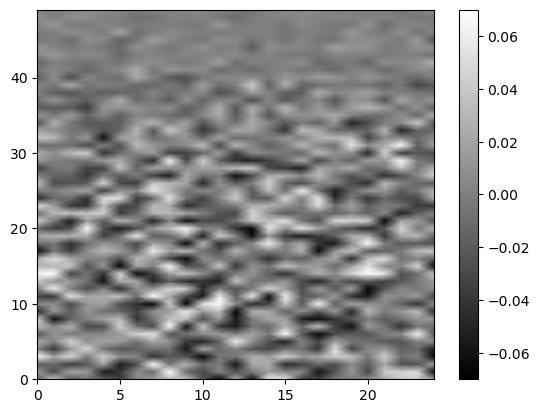

In [104]:
# Plot the covariance
fig, ax = plt.subplots()
X,Y = np.meshgrid(range(0, HRTFdata_full[0].HRTF_L.shape[0]),range(0, HRTFdata_full[0].HRTF_L.shape[1]))
surf = ax.pcolormesh(np.squeeze(SPC_L[4,:,:]).transpose(), shading='gouraud', cmap=cm.gray, clim=(-0.07,0.07))

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Show the plot
plt.show()

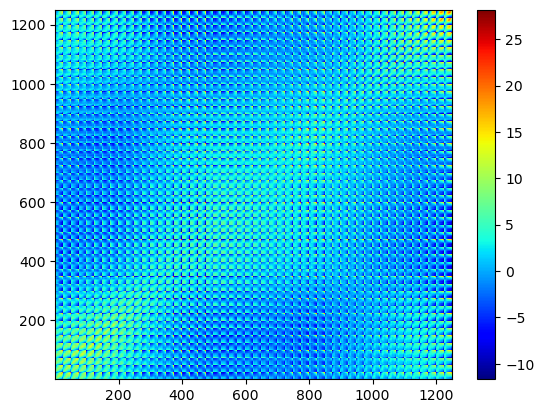

In [79]:
# Plot the covariance
fig, ax = plt.subplots()
X,Y = np.meshgrid(range(1,1251),range(1,1251))
surf = ax.pcolor(X,Y,COV_L, cmap=cm.jet)

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Show the plot
plt.show()

(1250, 1250)


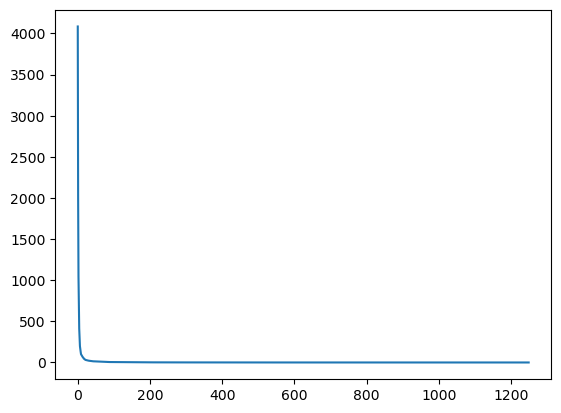

In [80]:
print(eigen_vecL.shape)
plt.plot(eigen_valL)

In [111]:
Hnew_L=np.zeros(np.append(H_L.shape,len(Nbases)))
Hnew_R=np.zeros(np.append(H_R.shape,len(Nbases)))
# Find strongest eigenvalues and decompose
for j in range(0,len(Nbases)):  
    eigen_vecProjL = eigen_vecL[:, 0:Nbases[j]].transpose() 
    eigen_valProjL = eigen_valL[0:Nbases[j]] # build reduced covar matrix
    eigen_vecProjR = eigen_vecR[:, 0:Nbases[j]].transpose() 
    eigen_valProjR = eigen_valR[0:Nbases[j]] 

    weights_L = np.matmul(H_L,eigen_vecProjL.transpose())  # matrix multiplication
    synth_L = np.matmul(weights_L,eigen_vecProjL)  
    weights_R = np.matmul(H_R,eigen_vecProjR.transpose())  # matrix multiplication
    synth_R = np.matmul(weights_R,eigen_vecProjR)  

    for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]): 
        for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
            # restore removed parts
            Hnew_L[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k,j] = synth_L[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k] + meanHRTFmagnew_L[k,l] # add back the mean spatial function at each direction
            Hnew_R[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k,j] = synth_R[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k] + meanHRTFmagnew_R[k,l]
    
for i in range(0,len(eigen_valL)):# calculate cumulative variance
    var_L[i]=np.sum(eigen_valL[0:i+1])/np.sum(eigen_valL)
    var_R[i]=np.sum(eigen_valR[0:i+1])/np.sum(eigen_valR)

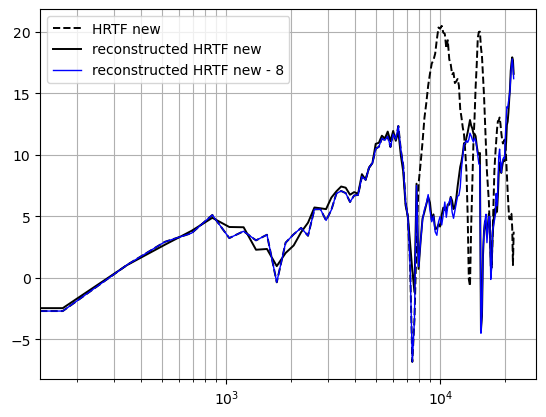

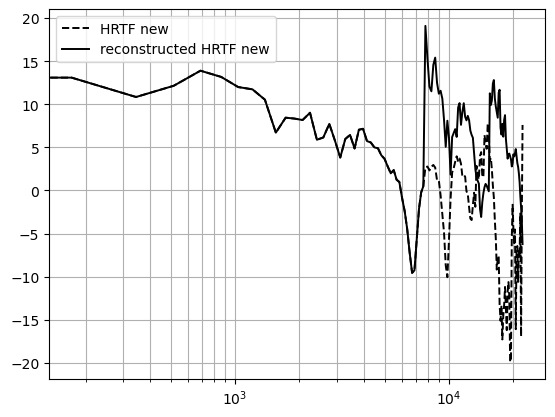

In [124]:
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Lnew[0,0,:],'--k',linewidth=1.4, label='HRTF new')
plt.semilogx(freq,Hnew_L[0:129,0,2],'k',linewidth=1.4, label='reconstructed HRTF new')
plt.semilogx(freq,Hnew_L[0:129,0,9],'b',linewidth=1, label='reconstructed HRTF new - 8')
plt.grid(True, which="both", ls="-")
plt.legend()

figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Rnewnew[0,0,:],'--k',linewidth=1.4, label='HRTF new')
plt.semilogx(freq,synth_R[0:129,0],'k',linewidth=1.4, label='reconstructed HRTF new')
plt.grid(True, which="both", ls="-")
plt.legend()

In [67]:
print(var_L[0:60])

[0.36093454 0.53792136 0.63017499 0.69444799 0.73095373 0.75877493
 0.77633589 0.79050237 0.8020362  0.81092987 0.81922522 0.82708382
 0.83402842 0.84022565 0.84598722 0.85122839 0.85593076 0.85991181
 0.86383843 0.86734179 0.87054844 0.87336327 0.87607109 0.87868952
 0.8811941  0.88358589 0.88590111 0.88807789 0.89022601 0.89226023
 0.89426172 0.89613689 0.89795241 0.89966536 0.90134306 0.90293994
 0.90448283 0.90602228 0.90746592 0.90888557 0.91026766 0.91158728
 0.91289475 0.91415237 0.91538997 0.91658138 0.91772416 0.91885152
 0.91993712 0.92100325 0.92202985 0.92303687 0.92401707 0.9249768
 0.92591459 0.92683968 0.9277568  0.92864797 0.92950789 0.93035172]


In [24]:
# save reconstructed HRTF
PCA_full=[]  # PCA_full is a list of instances HRTFSPCA
for i in range(0, len(HRTFdata_full)):
    PCAdata=HRTFSPCA()
    PCAdata.HRTFmag_Lsynth = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape),len(Nbases)))
    PCAdata.HRTFmag_Rsynth = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape),len(Nbases)))
    PCAdata.MSE_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))
    PCAdata.MSE_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))
    PCAdata.L2_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))
    PCAdata.L2_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))    
    for j in range(0, HRTFdata_full[0].HRTF_L.shape[2]):   
        for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]):
            for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
                for b in range(0, len(Nbases)):
                    PCAdata.HRTFmag_Lsynth[k,l,j,b] =  Hnew[len(HRTFdata_full)*i+j,HRTFdata_full[0].HRTF_L.shape[0]*l+k,b] + meanHRTFmag[j]# add back the mean of subjects and frequencies
                    PCAdata.HRTFmag_Rsynth[k,l,j,b] =  Hnew[len(HRTFdata_full)*HRTFdata_full[0].HRTF_L.shape[2]+len(HRTFdata_full)*i+j,HRTFdata_full[0].HRTF_L.shape[0]*l+k,b] + meanHRTFmag[j]

                    SE_l = np.sum(np.square(PCAdata.HRTFmag_Lsynth[k,l,:,b] - np.squeeze(np.abs(HRTFdata_full[i].HRTFmag_L[k,l,:]))))
                    SE_r = np.sum(np.square(PCAdata.HRTFmag_Rsynth[k,l,:,b] - np.squeeze(np.abs(HRTFdata_full[i].HRTFmag_R[k,l,:]))))
                    MSE_l = (1/HRTFdata_full[0].HRTF_L.shape[2]) * SE_l
                    MSE_r = (1/HRTFdata_full[0].HRTF_L.shape[2]) * SE_r
                    L2_l = np.sqrt(SE_l)
                    L2_r = np.sqrt(SE_r)
                    PCAdata.MSE_L[k,l,b] = MSE_l     # in dB
                    PCAdata.MSE_R[k,l,b] = MSE_r 
                    PCAdata.L2_L[k,l,b] = L2_l       # in dB
                    PCAdata.L2_R[k,l,b] = L2_r
    PCA_full.append(PCAdata)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


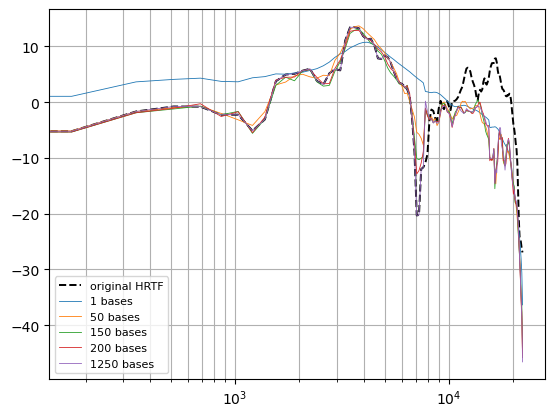

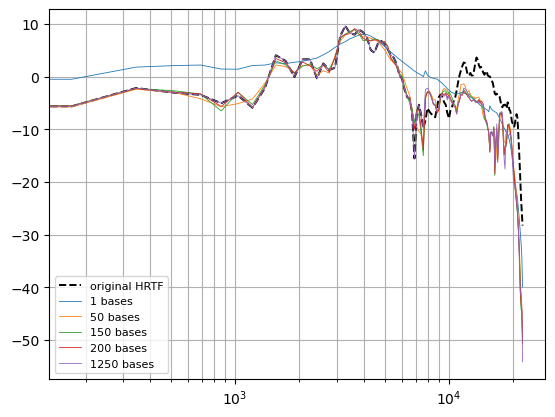

In [31]:

figure()
plt.semilogx(freq,HRTFdata_full[10].HRTFmag_L[10,10,:],'--k',linewidth=1.4, label='original HRTF')
for b in [0,2,4,5,9]:
    plt.semilogx(freq, HRTFdata_full[10].HRTFmag_Lsynth[10,10,:,b],linewidth=0.6,label=str(Nbases[b])+' bases')
plt.legend(fontsize="8")
plt.grid(True, which="both", ls="-")

figure()
plt.semilogx(freq,HRTFdata_full[10].HRTFmag_R[10,10,:],'--k',linewidth=1.4, label='original HRTF')
for b in [0,2,4,5,9]:
    plt.semilogx(freq, HRTFdata_full[10].HRTFmag_Rsynth[10,10,:,b],linewidth=0.6,label=str(Nbases[b])+' bases')
plt.legend(fontsize="8")
plt.grid(True, which="both", ls="-")

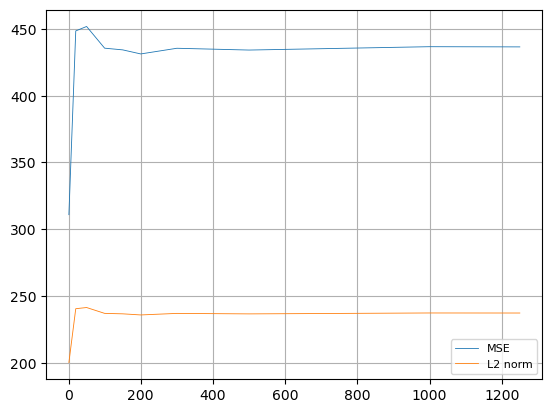

In [123]:
holdMSE=ndarray((len(Nbases)))
holdL2=ndarray((len(Nbases)))   
for b in range(0,len(Nbases)):
    holdMSE[b]=PCA_full[10].MSE_L[12,1,b]
    holdL2[b]=PCA_full[10].L2_L[12,1,b]
plt.plot(Nbases, holdMSE,linewidth=0.6,label='MSE')
plt.plot(Nbases, holdL2,linewidth=0.6,label='L2 norm')
plt.grid(True)
plt.legend(fontsize="8")

In [9]:
## Key anthropometric parameters selection 
data_dir = pjoin('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/anthropometry/')
mat_fname = pjoin(data_dir, 'anthro.mat')
anth_data=sio.loadmat(mat_fname)
anth=np.zeros((len(anth_data),14))
X=anth_data.get('X')
D=anth_data.get('D')
for i in range(0, len(anth_data)):
    anth[i,0]=X[i,0]
    anth[i,1]=X[i,2]
    anth[i,2]=X[i,3]
    anth[i,3]=X[i,11]
    anth[i,4]=D[i,0]
    anth[i,5]=D[i,2]
    anth[i,6]=D[i,3]
    anth[i,7]=D[i,4]
    anth[i,8]=D[i,5]
    anth[i,9]=D[i,8]
    anth[i,10]=D[i,10]
    anth[i,11]=D[i,11]
    anth[i,12]=D[i,12]
    anth[i,13]=D[i,13]

In [ ]:
## DNN
# define the keras model
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(101, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(anth, HRTFdata_full[0].HRTFmag_Lsynth[:,:,0,0], epochs=150, batch_size=10)

# evaluate the keras model
_, accuracy = model.evaluate(anth, HRTFdata_full[0].HRTFmag_Lsynth[:,:,0,0])
